# Train ML model to correct predictions of week 3-4 & 5-6

This notebook create a Machine Learning `ML_model` to predict weeks 3-4 & 5-6 based on `S2S` weeks 3-4 & 5-6 forecasts and is compared to `CPC` observations for the [`s2s-ai-challenge`](https://s2s-ai-challenge.github.io/).

# Synopsis

## Method: `mean bias reduction`

- calculate the mean bias from 2000-2019 deterministic ensemble mean forecast
- remove that mean bias from 2020 forecast deterministic ensemble mean forecast

## Data used

type: renku datasets

Training-input for Machine Learning model:
- hindcasts of models:
    - ECMWF: `ecmwf_hindcast-input_2000-2019_biweekly_deterministic`

Forecast-input for Machine Learning model:
- real-time 2020 forecasts of models:
    - ECMWF: `ecmwf_forecast-input_2020_biweekly_deterministic`

Compare Machine Learning model forecast against against ground truth:
- `CPC` observations:
    - `hindcast-like-observations_biweekly_deterministic`
    - `forecast-like-observations_2020_biweekly_deterministic`

## Resources used
for training

- platform: MPI-M supercompute 1 Node
- memory: 64 GB
- processors: 36 CPU
- storage required: 10 GB

## Safeguards

All points have to be [x] checked. If not, your submission is invalid.

Changes to the code after submissions are not possible, as the `commit` before the `tag` will be reviewed.
(Only in exceptions and if previous effort in reproducibility can be found, it may be allowed to improve readability and reproducibility after November 1st 2021.)

### Safeguards to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting?wprov=sfti1) 

If the organizers suspect overfitting, your contribution can be disqualified.

  - [x] We didnt use 2020 observations in training (explicit overfitting and cheating)
  - [x] We didnt repeatedly verify my model on 2020 observations and incrementally improved my RPSS (implicit overfitting)
  - [x] We tried our best to prevent [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)?wprov=sfti1).
  - [x] We honor the `train-validate-test` [split principle](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). This means that the hindcast data is split into `train` and `validate`, whereas `test` is withheld.
  - [x] We did use `test` explicitly in training or implicitly in incrementally adjusting parameters.
  - [x] We considered [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

### Safeguards for Reproducibility
Notebook/code must be independently reproducible from scratch by the organizers (after the competition), if not possible: no prize
  - [x] All training data is publicly available (no pre-trained private neural networks, as they are not reproducible for us)
  - [x] Code is well documented, readable and reproducible.
  - [x] Code to reproduce runs within a day.

# Todos to improve template

This is just a demo.

- [ ] use multiple predictor variables and two predicted variables
- [ ] for both `lead_time`s in one go
- [ ] consider seasonality, for now all `forecast_time` months are mixed
- [ ] make probabilistic predictions with `category` dim, for now works deterministic

# Imports

In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import xarray as xr
xr.set_options(display_style='text')

from dask.utils import format_bytes
import xskillscore as xs

# Get training data

preprocessing of input data may be done in separate notebook/script

## Hindcast

get weekly initialized hindcasts

In [3]:
v='t2m'

In [42]:
# preprocessed as renku dataset
!renku storage pull ../data/ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr

In [4]:
hind_2000_2019 = xr.open_zarr("../data/ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr", consolidated=True)#[v]

In [44]:
# preprocessed as renku dataset
!renku storage pull ../data/ecmwf_forecast-input_2020_biweekly_deterministic.zarr

In [5]:
fct_2020 = xr.open_zarr("../data/ecmwf_forecast-input_2020_biweekly_deterministic.zarr", consolidated=True)#[v]

## Observations
corresponding to hindcasts

In [46]:
# preprocessed as renku dataset
!renku storage pull ../data/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr

In [6]:
obs_2000_2019 = xr.open_zarr("../data/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr", consolidated=True)#[v]

In [48]:
# preprocessed as renku dataset
!renku storage pull ../data/forecast-like-observations_2020_biweekly_deterministic.zarr

In [7]:
obs_2020 = xr.open_zarr("../data/forecast-like-observations_2020_biweekly_deterministic.zarr", consolidated=True)#[v]

# ML model

based on [Weatherbench](https://github.com/pangeo-data/WeatherBench/blob/master/quickstart.ipynb)

In [ ]:
# run once only and dont commit
!git clone https://github.com/pangeo-data/WeatherBench/

In [16]:
import sys
sys.path.insert(1, 'WeatherBench')
from WeatherBench.src.train_nn import DataGenerator, PeriodicConv2D, create_predictions
import tensorflow.keras as keras

In [17]:
bs=32

import numpy as np
class DataGenerator(keras.utils.Sequence):
    def __init__(self, fct, verif, lead_time, batch_size=bs, shuffle=True, load=True,
                 mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

        Args:
            fct: forecasts from S2S models: xr.DataArray (xr.Dataset doesnt work properly)
            verif: observations with same dimensionality (xr.Dataset doesnt work properly)
            lead_time: Lead_time as in model
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
            
        Todo:
        - use number in a better way, now uses only ensemble mean forecast
        - dont use .sel(lead_time=lead_time) to train over all lead_time at once
        - be sensitive with forecast_time, pool a few around the weekofyear given
        - use more variables as predictors
        - predict more variables
        """

        if isinstance(fct, xr.Dataset):
            print('convert fct to array')
            fct = fct.to_array().transpose(...,'variable')
            self.fct_dataset=True
        else:
            self.fct_dataset=False
            
        if isinstance(verif, xr.Dataset):
            print('convert verif to array')
            verif = verif.to_array().transpose(...,'variable')
            self.verif_dataset=True
        else:
            self.verif_dataset=False
        
        #self.fct = fct
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        self.fct_data = fct.transpose('forecast_time', ...).sel(lead_time=lead_time)
        self.fct_mean = self.fct_data.mean('forecast_time').compute() if mean is None else mean
        self.fct_std = self.fct_data.std('forecast_time').compute() if std is None else std
        
        self.verif_data = verif.transpose('forecast_time', ...).sel(lead_time=lead_time)
        self.verif_mean = self.verif_data.mean('forecast_time').compute() if mean is None else mean
        self.verif_std = self.verif_data.std('forecast_time').compute() if std is None else std

        # Normalize
        self.fct_data = (self.fct_data - self.fct_mean) / self.fct_std
        self.verif_data = (self.verif_data - self.verif_mean) / self.verif_std
        
        self.n_samples = self.fct_data.forecast_time.size
        self.forecast_time = self.fct_data.forecast_time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.fct_data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        # got all nan if nans not masked
        X = self.fct_data.isel(forecast_time=idxs).fillna(0.).values
        y = self.verif_data.isel(forecast_time=idxs).fillna(0.).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [18]:
# 2 bi-weekly `lead_time`: week 3-4
lead = hind_2000_2019.isel(lead_time=0).lead_time

lead

<xarray.DataArray 'lead_time' ()>
array(1209600000000000, dtype='timedelta64[ns]')
Coordinates:
    lead_time  timedelta64[ns] 14 days
Attributes:
    comment:  lead_time describes bi-weekly aggregates. The pd.Timedelta corr...

In [19]:
# mask
hind_2000_2019 = hind_2000_2019.where(obs_2000_2019.isel(forecast_time=0, lead_time=0,drop=True).notnull())

## data prep: train, valid, test

[Use the hindcast period to split train and valid.](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) Do not use the 2020 data for testing!

In [20]:
# time is the forecast_time
time_train_start,time_train_end='2000','2017' # train
time_valid_start,time_valid_end='2018','2019' # valid
time_test = '2020'                            # test

In [21]:
dg_train = DataGenerator(
    hind_2000_2019.mean('realization').sel(forecast_time=slice(time_train_start,time_train_end))[v],
    obs_2000_2019.sel(forecast_time=slice(time_train_start,time_train_end))[v],
    lead_time=lead, batch_size=bs, load=True)

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Loading data into RAM


/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [22]:
dg_valid = DataGenerator(
    hind_2000_2019.mean('realization').sel(forecast_time=slice(time_valid_start,time_valid_end))[v],
    obs_2000_2019.sel(forecast_time=slice(time_valid_start,time_valid_end))[v],
    lead_time=lead, batch_size=bs, shuffle=False, load=True)

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Loading data into RAM


In [23]:
# do not use, delete?
dg_test = DataGenerator(
    fct_2020.mean('realization').sel(forecast_time=time_test)[v],
    obs_2020.sel(forecast_time=time_test)[v],
    lead_time=lead, batch_size=bs, load=True, mean=dg_train.fct_mean, std=dg_train.fct_std, shuffle=False)

Loading data into RAM


In [24]:
X, y = dg_valid[0]
X.shape, y.shape

((32, 121, 240), (32, 121, 240))

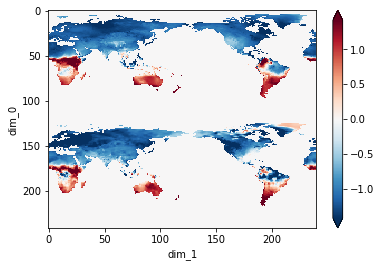

In [25]:
# short look into training data: large biases
# any problem from normalizing?
i=4
xr.DataArray(np.vstack([X[i],y[i]])).plot(yincrease=False, robust=True)

## `fit`

In [26]:
cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1)),
    PeriodicConv2D(filters=1, kernel_size=5)
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
periodic_conv2d (PeriodicCon (None, 32, 64, 32)        832       
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 32, 64, 1)         801       
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [28]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [29]:
import warnings
warnings.simplefilter("ignore")

In [30]:
cnn.fit(dg_train, epochs=3, validation_data=dg_valid)

Epoch 1/3
30/30 [==============================] - 19s 491ms/step - loss: 0.1931 - val_loss: 0.1190
Epoch 2/3
30/30 [==============================] - 14s 454ms/step - loss: 0.1170 - val_loss: 0.0769
Epoch 3/3
30/30 [==============================] - 14s 454ms/step - loss: 0.0777 - val_loss: 0.0624


## `predict` 2020

In [33]:
from scripts import add_valid_time_from_forecast_reference_time_and_lead_time

def create_predictions(model, dg, lead):
    """Create non-iterative predictions"""
    preds = model.predict(dg).squeeze()
    # Unnormalize
    preds = preds * dg.fct_std.values + dg.fct_mean.values
    if dg.verif_dataset:
        da = xr.DataArray(
                    preds,
                    dims=['forecast_time', 'latitude', 'longitude','variable'],
                    coords={'forecast_time': dg.fct_data.forecast_time, 'latitude': dg.fct_data.latitude,
                            'longitude': dg.fct_data.longitude},
                ).to_dataset()
    else:
        da = xr.DataArray(
                    preds,
                    dims=['forecast_time', 'latitude', 'longitude'],
                    coords={'forecast_time': dg.fct_data.forecast_time, 'latitude': dg.fct_data.latitude,
                            'longitude': dg.fct_data.longitude},
                )
    da = da.assign_coords(lead_time=lead)
    # da = add_valid_time_from_forecast_reference_time_and_lead_time(da)
    return da

In [34]:
preds = create_predictions(cnn, dg_test, lead)

In [35]:
preds.coords

Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    lead_time      timedelta64[ns] 14 days

#### predict over all steps

In [36]:
# this is not useful but results have expected dimensions
# actually train for each lead_time

preds=[]
for step in hind_2000_2019.lead_time:
    dg_test = DataGenerator(fct_2020.mean('realization').sel(forecast_time=slice(time_test))[v], obs_2020[v],
                        lead_time=lead, batch_size=bs, mean=dg_train.fct_mean, std=dg_train.fct_std, shuffle=False)
    preds.append(create_predictions(cnn, dg_test, lead))
preds = xr.concat(preds, 'lead_time')
preds['lead_time']=hind_2000_2019.lead_time
preds = add_valid_time_from_forecast_reference_time_and_lead_time(preds)
preds=preds.to_dataset(name=v)

Loading data into RAM
Loading data into RAM


In [37]:
preds.coords

Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
    valid_time     (lead_time, forecast_time) datetime64[ns] 2020-01-16 ... 2...

### convert preds to preds_as_terciles

In [38]:
mask = obs_2020.std(['lead_time','forecast_time']).notnull()

In [39]:
from scripts import make_probabilistic

In [ ]:
!renku storage pull ../data/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc

In [49]:
cache_path='../data'
tercile_file = f'{cache_path}/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc'
tercile_edges = xr.open_dataset(tercile_file).rename({'weekofyear':'forecast_time'}).assign_coords(forecast_time=obs_2020.forecast_time)

In [50]:
# converting realization mean prediction into binary forecast probabilities
submission = make_probabilistic(preds.expand_dims('realization'), tercile_edges, mask=mask)

In [57]:
# submission[v].isel(forecast_time=0).plot(col='category', row='lead_time', robust=True)

# Submission

In [51]:
v

't2m'

In [52]:
# add a fake second variable
submission['tp'] = submission[v]

In [53]:
submission.sizes # expect: category(3), longitude, latitude, lead_time(2), forecast_time (53)

Frozen(SortedKeysDict({'category': 3, 'lead_time': 2, 'forecast_time': 53, 'latitude': 121, 'longitude': 240}))

In [54]:
format_bytes(submission.nbytes)

'147.76 MB'

In [55]:
submission.to_netcdf('../submissions/ML_prediction_2020.nc')

In [ ]:
#!git add ../submissions/ML_prediction_2020.nc

In [ ]:
#git commit -m "commit submission for my_method"
#git tag "submission-my_method-0.0.1" # if this is to be checked by scorer

In [ ]:
#git push --tags

# Reproducibility

## memory

In [8]:
# https://phoenixnap.com/kb/linux-commands-check-memory-usage
!free -g

             total       used       free     shared    buffers     cached
Mem:            62          4         58          0          0          1
-/+ buffers/cache:          3         59
Swap:            0          0          0


## CPU

In [5]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                72
On-line CPU(s) list:   0-71
Thread(s) per core:    2
Core(s) per socket:    18
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2695 v4 @ 2.10GHz
Stepping:              1
CPU MHz:               2100.000
BogoMIPS:              4190.01
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K
NUMA node0 CPU(s):     0-17,36-53
NUMA node1 CPU(s):     18-35,54-71


## software

In [6]:
!conda list

# packages in environment at /work/mh0727/m300524/conda-envs/s2s-ai:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_tflow_select             2.3.0                       mkl  
absl-py                   0.12.0           py37h06a4308_0  
aiobotocore               1.2.2              pyhd3eb1b0_0  
aiohttp                   3.7.4            py37h27cfd23_1  
aioitertools              0.7.1              pyhd3eb1b0_0  
anyio                     2.2.0                    pypi_0    pypi
appdirs                   1.4.4                      py_0  
argcomplete               1.12.2                   pypi_0    pypi
argon2-cffi               20.1.0           py37h27cfd23_1  
asciitree                 0.3.3                      py_2  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py37h06a4308_0  
async_generator           1.10             py37h28b3542_0  
attrs     